<a href="https://colab.research.google.com/github/matand380/DNN_final_project_2024/blob/main/DNN_final_project_2024_with_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project** 🖥

## Team Information
- **Course:** Introduction to Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690

## Project Overview

### Objective

This project centers around the application of deep learning techniques to classify chest X-ray images into distinct categories,

with a specific emphasis on differentiating between healthy cases and those diagnosed with pneumonia.

The dataset for training and evaluation includes a total of 5863 X-ray images, categorized as follows:

- A. **Healthy**
- B. **Pneumonia**
  - Bacterial Pneumonia
  - Viral Pneumonia



### Define imports
**always run the above cell first:**

In [46]:
import gdown
import os
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, Conv2DTranspose
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall
from keras import backend as K


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

from google.colab import drive

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam



# Dataset Downloading and Exploration

### Prerequisites

Execute the code cell below to download the dataset ZIP file from Google Drive and extract its contents.

In [2]:

file_id = '1-7nq09-oeUTz5wk5hUre3wEiDfuESb52'

output_path = '/content/chest-xray-pneumonia.zip'  # Adjust the output path as needed

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

!unzip chest-xray-pneumonia.zip

Downloading...
From (original): https://drive.google.com/uc?id=1-7nq09-oeUTz5wk5hUre3wEiDfuESb52
From (redirected): https://drive.google.com/uc?id=1-7nq09-oeUTz5wk5hUre3wEiDfuESb52&confirm=t&uuid=81170a6b-c78d-4acf-abfb-08a78b36f041
To: /content/chest-xray-pneumonia.zip
100%|██████████| 2.46G/2.46G [00:35<00:00, 68.8MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Data exploration

Let's begin by exploring a selection of images accompanied by brief explanations about the dataset.

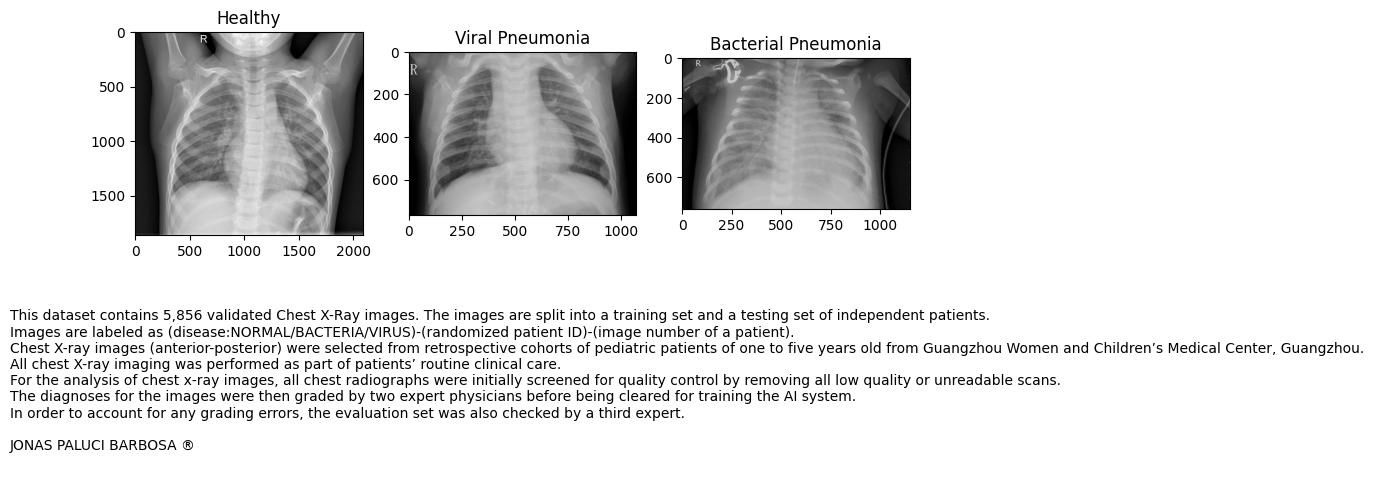

In [ ]:

healthy_image_path = '/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
viral_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'
bacterial_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'

healthy_image = cv2.imread(healthy_image_path)
viral_pneumonia_image = cv2.imread(viral_pneumonia_image_path)
bacterial_pneumonia_image = cv2.imread(bacterial_pneumonia_image_path)

# Convert BGR images to RGB
healthy_image = cv2.cvtColor(healthy_image, cv2.COLOR_BGR2RGB)
viral_pneumonia_image = cv2.cvtColor(viral_pneumonia_image, cv2.COLOR_BGR2RGB)
bacterial_pneumonia_image = cv2.cvtColor(bacterial_pneumonia_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(healthy_image)
plt.title('Healthy')

plt.subplot(1, 3, 2)
plt.imshow(viral_pneumonia_image)
plt.title('Viral Pneumonia')

plt.subplot(1, 3, 3)
plt.imshow(bacterial_pneumonia_image)
plt.title('Bacterial Pneumonia')
text = """
This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients.
Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.
All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.
The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system.
In order to account for any grading errors, the evaluation set was also checked by a third expert.

JONAS PALUCI BARBOSA ®
"""

plt.figtext(0.0, -0.000000000015, text, size=10, ha="left", va="center")


plt.show()


Let's examine the distribution of targets within each set.

In [3]:


def create_dataframe_from_directory(directory):
    file_paths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            file_paths.append(file_path)
            labels.append(label)
    return pd.DataFrame({'file_path': file_paths, 'class': labels})

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# DataFrames
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)

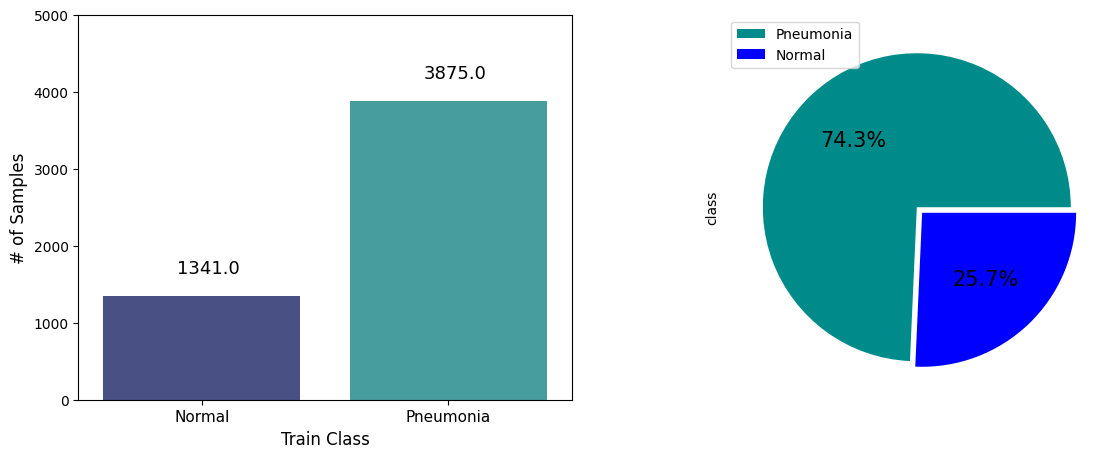

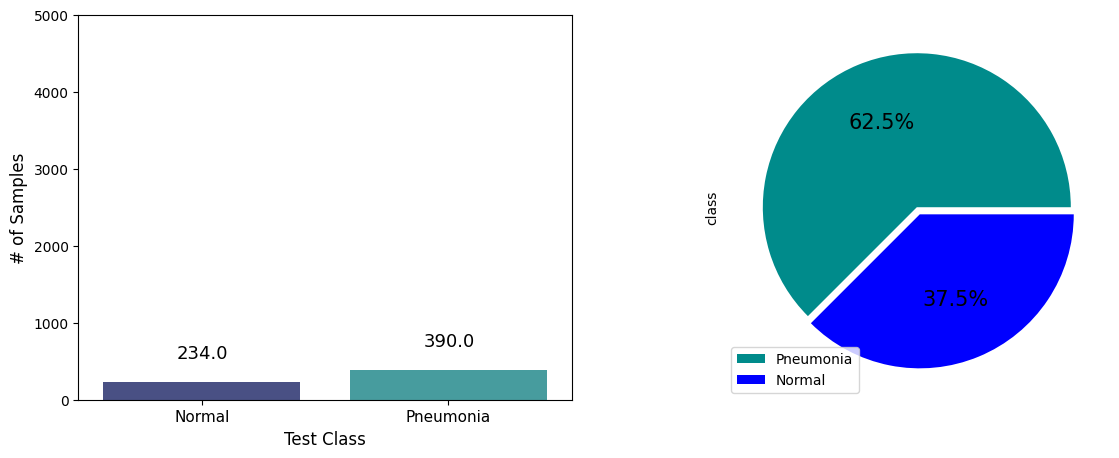

In [ ]:
#Graphs for the train set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = sns.countplot(x='class', hue='class', data=train_df, palette="mako", ax=axes[0], legend=False)
ax1.set_xlabel("Train Class", fontsize=12)
ax1.set_ylabel("# of Samples", fontsize=12)
ax1.set_ylim(0, 5000)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Normal', 'Pneumonia'], fontsize=11)

for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() + 0.30, p.get_height() + 300), fontsize=13)

ax2 = axes[1]
train_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=['darkcyan', 'blue'],
                                      explode=[0, 0.05], textprops={"fontsize": 15})
ax2.legend(labels=['Pneumonia', 'Normal'])

plt.show()

#Graphs for the test set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = sns.countplot(x='class', hue='class', data=test_df, palette="mako", ax=axes[0], legend=False)
ax1.set_xlabel("Test Class", fontsize=12)
ax1.set_ylabel("# of Samples", fontsize=12)
ax1.set_ylim(0, 5000)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Normal', 'Pneumonia'], fontsize=11)

for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() + 0.30, p.get_height() + 300), fontsize=13)


ax2 = axes[1]
test_df['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=['darkcyan', 'blue'],
                                      explode=[0, 0.05], textprops={"fontsize": 15})
ax2.legend(labels=['Pneumonia', 'Normal'])

plt.show()


# Binary classification - Healthy vs Pneumonia
In this section, the aim is to implement a binary classification neural network to distinguish between healthy and diseased images.

## Preprocessing - Data augmentation and normalization

In [4]:

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

## Reorganization of the data

In the original data there's only 16 samples for the validation set. At the first training we got overfitting so we reorganized the samples in order to get more balanced data.

In [5]:

# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files)

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True

)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
     shuffle=False
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
     shuffle=False

)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Custom Model from scratch


- We tried setting the lreaning rate to 0.01 but we got worse results than 0.
001 (which is the default for Adam optimizer). Afterwards we changed it to 0.0001.

- We discovered that adding more convolutional layers improve the network ability to learn more hierarchical features and got much better results.

- We increased the dense layer from 128 to 2048 because we thought we are loosing important information. afterwards we added one more dense layer.

- We added L2 regularization

In [ ]:

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))) #0.01 soft regularization
model.add(Conv2D(filters=32,kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(Conv2D(filters=64,kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(units=2048, activation='relu', kernel_regularizer=l2(0.01),name='ev'))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [20]:
drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/DNN_final_project_2024'

Mounted at /content/gdrive


In [ ]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/binary_best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 9.4356 - accuracy: 0.7254

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 133s 988ms/step - loss: 9.4356 - accuracy: 0.7254 - val_loss: 3.4031 - val_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 137s 1s/step - loss: 2.6017 - accuracy: 0.7422 - val_loss: 2.0059 - val_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 142s 1s/step - loss: 1.6965 - accuracy: 0.7438 - val_loss: 1.4330 - val_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 132s 1s/step - loss: 1.2642 - accuracy: 0.7422 - val_loss: 1.1269 - val_accuracy: 0.7421
Epoch 5/10
 24/131 [====>.........................] - ETA: 1:41 - loss: 1.1170 - accuracy: 0.7344

KeyboardInterrupt: 

In [ ]:
print("Training Accuracy:", round(history.history['accuracy'][-1], 3))
print("Training Loss:", round(history.history['loss'][-1], 3))
print("Validation Accuracy:", round(history.history['val_accuracy'][-1], 3))
print("Validation Loss:", round(history.history['val_loss'][-1], 3))

Training Accuracy: 0.868
Training Loss: 0.487
Validation Accuracy: 0.928
Validation Loss: 0.377


In [ ]:
model.save(f'{drive_path}/binary_best_model.h5')

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Show the plots
    plt.tight_layout()
    plt.show()

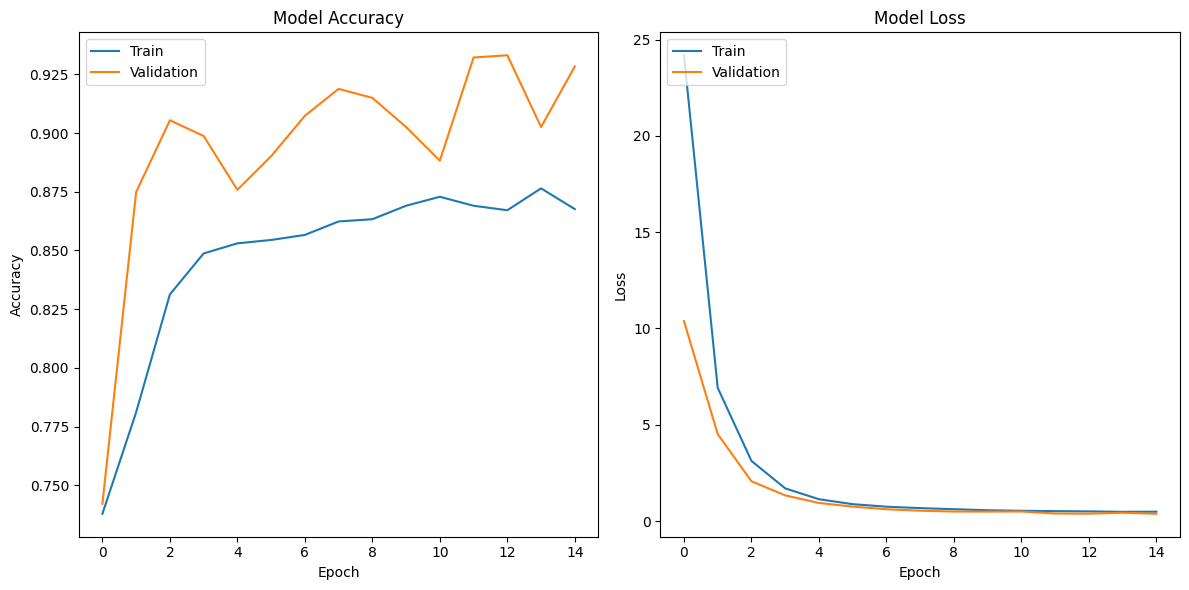

In [ ]:
plot_training_history(history)

### Evaluate the model

In [ ]:

binary_model = load_model(f'{drive_path}/binary_best_model.h5')
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluation_result = binary_model.evaluate(test_generator, steps=len(test_generator))

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


20/20 [==============================] - 13s 517ms/step - loss: 0.5328 - accuracy: 0.8510
Test Loss: 0.5328
Test Accuracy: 85.10%


20/20 [==============================] - 6s 268ms/step
Accuracy: 87.66%



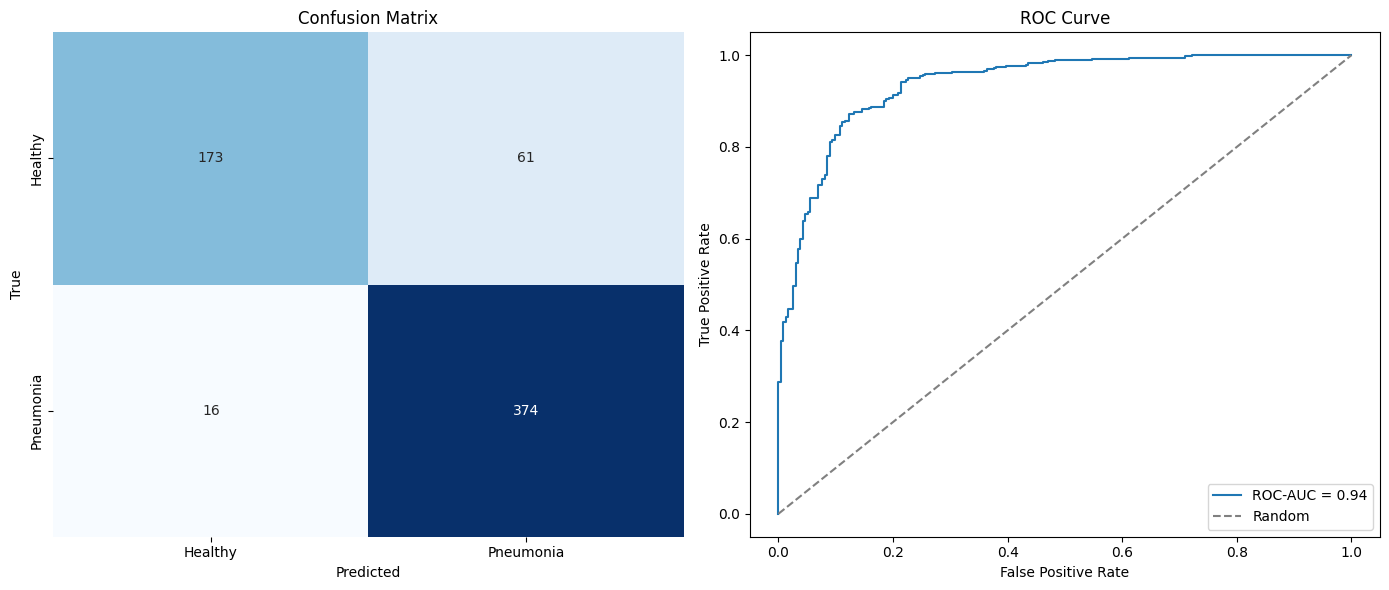

In [ ]:
# Make predictions on the test set
y_pred_prob = binary_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5)

y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print()

class_labels = ['Healthy', 'Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix')

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
axes[1].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()


# Multi-class classification - Healthy, Viral and Bacteria
In this task, the objective is to address the problem using a deep neural network for multi-class classification. The network will categorize images into three classes: healthy, diseased with viral pneumonia, and diseased with bacterial pneumonia. in this implementation we chose to use transfer learning technique.

In [ ]:
# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Function to extract labels from file paths
def extract_labels(file_paths):
    labels = []
    for file_path in file_paths:
        if 'virus' in file_path:
            labels.append('viral')
        elif 'bacteria' in file_path:
            labels.append('bacterial')
        else:
            labels.append('normal')
    return labels

all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files)

test_files = []
for root, dirs, files in os.walk(test_dir):
    test_files.extend([os.path.join(root, file) for file in files])

# Extract labels from file paths
labels = extract_labels(all_files)
test_labels = extract_labels(test_files)


# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4185 validated image filenames belonging to 3 classes.
Found 1047 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


- First, we trained with lr=0.01 than we changed to 0.001

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False)

In [ ]:
temp_model = base_model.output
temp_model=GlobalAveragePooling2D()(temp_model)
temp_model=Dense(units=1024, activation='relu')(temp_model)
temp_model=Dense(units=1024, activation='relu')(temp_model)
temp_model=Dense(units=512, activation='relu')(temp_model)
preds = Dense(3, activation='softmax')(temp_model)

In [ ]:
multi_class_model= Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in multi_class_model.layers[:-4]:
  layer.trainable=False

In [ ]:
optimizer_tl = Adam(learning_rate=0.001)
multi_class_model.compile(optimizer=optimizer_tl, loss='categorical_crossentropy', metrics=['accuracy'])
multi_class_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/multi_class_best_model.h5', save_best_only=True)

spe = train_generator.n // train_generator.batch_size
spe_val = val_generator.n // val_generator.batch_size

history_multi_class = multi_class_model.fit(train_generator, steps_per_epoch=spe, epochs=10, validation_data=val_generator, validation_steps=spe_val, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7216

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 55s 401ms/step - loss: 0.6751 - accuracy: 0.7216 - val_loss: 0.4347 - val_accuracy: 0.8086
Epoch 2/10
130/130 [==============================] - 49s 381ms/step - loss: 0.4582 - accuracy: 0.8030 - val_loss: 0.4414 - val_accuracy: 0.8203
Epoch 3/10
130/130 [==============================] - 61s 469ms/step - loss: 0.4303 - accuracy: 0.8100 - val_loss: 0.4717 - val_accuracy: 0.7871
Epoch 4/10
130/130 [==============================] - 50s 382ms/step - loss: 0.4309 - accuracy: 0.8069 - val_loss: 0.4391 - val_accuracy: 0.8066


In [ ]:
print("Transfer learning metrics:")
print("Training Accuracy:", round(history_multi_class.history['accuracy'][-1], 3))
print("Training Loss:", round(history_multi_class.history['loss'][-1], 3))
print("Validation Accuracy:", round(history_multi_class.history['val_accuracy'][-1], 3))
print("Validation Loss:", round(history_multi_class.history['val_loss'][-1], 3))

Transfer learning metrics:
Training Accuracy: 0.807
Training Loss: 0.431
Validation Accuracy: 0.807
Validation Loss: 0.439


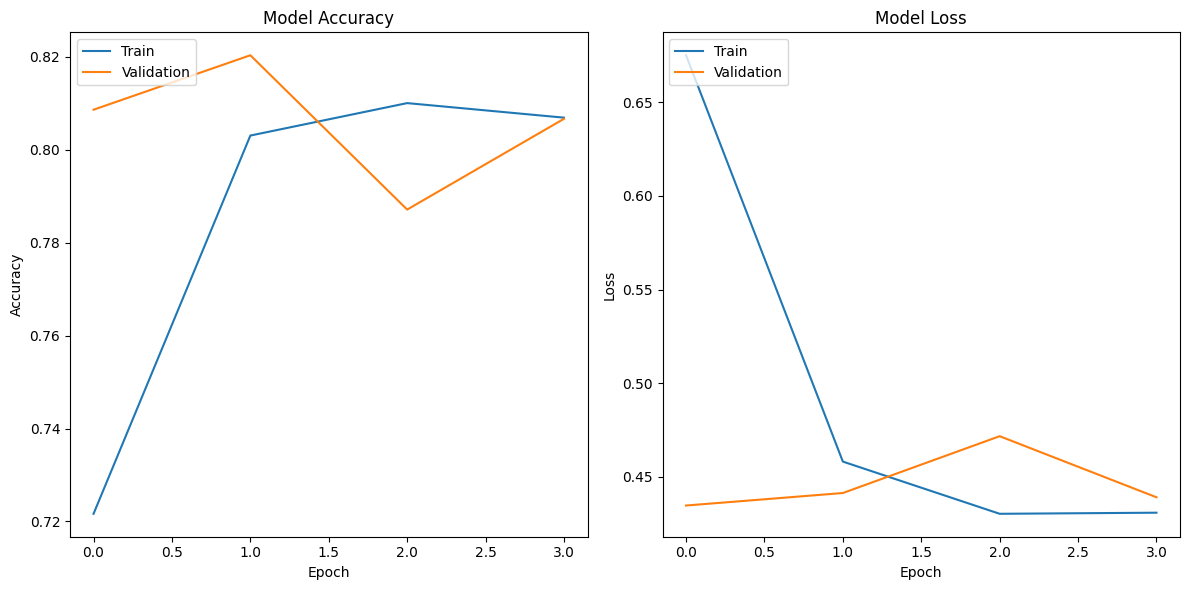

In [ ]:
plot_training_history(history_multi_class)

In [ ]:
multi_class_model.save(f'{drive_path}/multi_class_best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

model_tl = load_model(f'{drive_path}/multi_class_best_model.h5')
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluation_result = model_tl.evaluate(test_generator)

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


20/20 [==============================] - 11s 344ms/step - loss: 1.7090 - accuracy: 0.3750
Test Loss: 1.7090
Test Accuracy: 37.50%


33/33 [==============================] - 10s 308ms/step
Accuracy: 80.99%


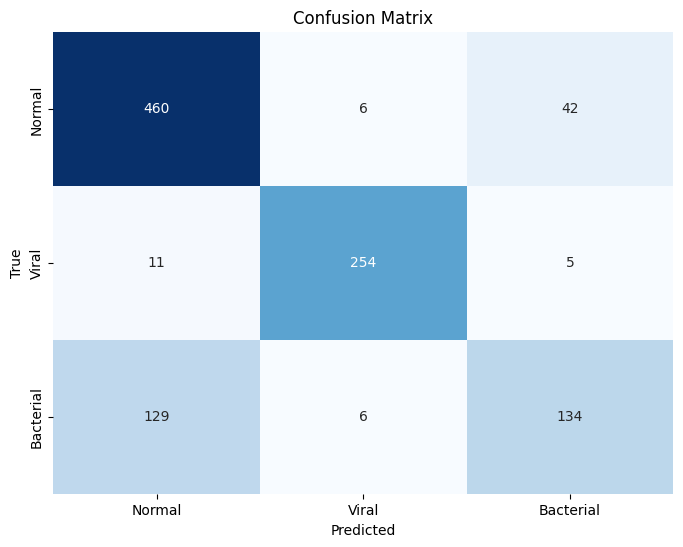

In [ ]:


y_pred = multi_class_model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)

y_true = val_generator.classes

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Define class labels
class_labels = ['Normal', 'Viral', 'Bacterial']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# KNN classification
In the subsequent code, we will demonstrate the application of a previously identified successful neural network for classifying new images. The process involves leveraging the embedding vector generated by the classification network and implementing KNN for image classification.

## Binary KNN classification

20/20 [==============================] - 6s 264ms/step
Mean of embedding vectors: [0. 0. 0. ... 0. 0. 0.]
Standard deviation of embedding vectors: [0. 0. 0. ... 0. 0. 0.]
Accuracy on test set: 0.6121794871794872


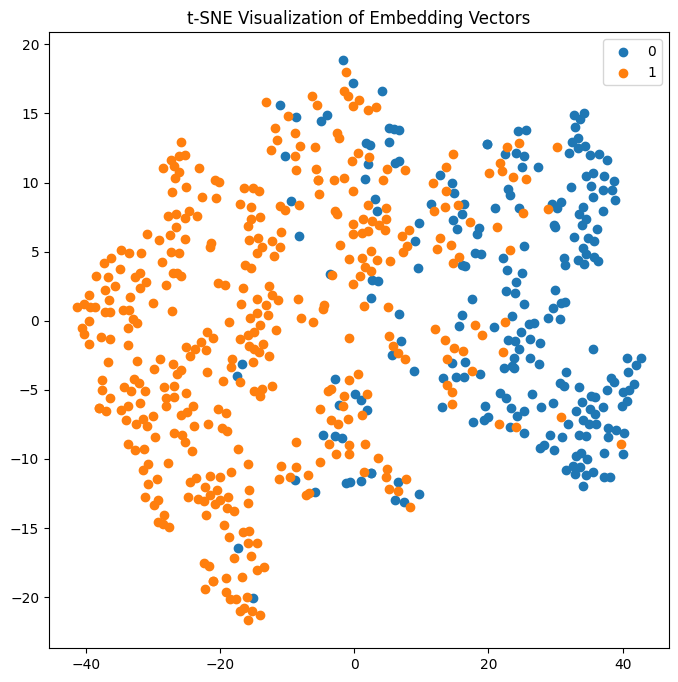

In [ ]:
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

embedding_model = Model(inputs=binary_model.input, outputs=binary_model.get_layer('ev').output)


train_embeddings = embedding_model.predict(train_generator)
train_labels = train_generator.classes

test_embeddings = embedding_model.predict(test_generator)
test_labels = test_generator.classes

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings)

knn_classifier = KNeighborsClassifier(n_neighbors=5) # An arbitrary choice
knn_classifier.fit(train_embeddings_tsne, train_labels)

# Transform test embeddings using the same t-SNE model
test_embeddings_tsne = tsne.fit_transform(test_embeddings)
test_predictions = knn_classifier.predict(test_embeddings_tsne)

accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy on test set: {accuracy}')

# Plot the t-SNE visualization
plt.figure(figsize=(8, 8))
for label in np.unique(test_labels):
    plt.scatter(test_embeddings_tsne[test_labels == label, 0], test_embeddings_tsne[test_labels == label, 1], label=label)
plt.title('t-SNE Visualization of Embedding Vectors')
plt.legend()
plt.show()


# Anomaly Detection
In this section, we exclusively possess data for "healthy" images. The objective is to implement anomaly detection techniques to identify potentially "diseased" images. By training models on healthy images and detecting deviations or reconstruction errors, we aim to uncover anomalies indicative of diseases or abnormalities.

In [17]:
# DataFrames
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)
batch_size=32

normal_datagen = ImageDataGenerator( # add augmentations
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_normal_df = train_df[train_df['class'] == 'NORMAL']

normal_generator = normal_datagen.flow_from_dataframe(
    dataframe=train_normal_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input',
    shuffle=True,
)

test_generator.class_mode='input'

val_splitted_df,test_splitted_df  = train_test_split(test_df, test_size=0.2, shuffle=True, random_state=42)


val_ae_datagen = ImageDataGenerator(
    rescale=1./255
)
val_ae_generator = val_ae_datagen.flow_from_dataframe(
    dataframe=val_splitted_df,
    x_col='file_path',
    y_col='class',
     target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input',
    shuffle=False
)
test_ae_datagen = ImageDataGenerator(
    rescale=1./255
)
test_ae_generator = test_ae_datagen.flow_from_dataframe(
    dataframe=test_splitted_df,
    x_col='file_path',
    y_col='class',
     target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input',
    shuffle=False
)


Found 1341 validated image filenames.
Found 499 validated image filenames.
Found 125 validated image filenames.


In [61]:
# Define custom precision, recall, and F1-score metrics functions
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


input_shape=(224, 224, 3)
inputs = Input(shape=input_shape)

# Encoder
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(inputs)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
# x = MaxPooling2D((2,2), padding='same')(x)
encoded = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)

# Decoder
x = Conv2DTranspose(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(encoded)
x = Conv2DTranspose(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)
decoded = Conv2DTranspose(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same', strides=2)(x)

# Autoencoder Model
autoencoder = Model(inputs, decoded)
ae_optimizer=Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=ae_optimizer, loss='mse', metrics=[precision, recall, f1_score])

autoencoder.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_transpose_24 (Conv2  (None, 28, 28, 128)       147584    
 DTranspose)                                               

In [62]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/ae_best_model.h5', save_best_only=True)

#Train the autoencoder
ae_history = autoencoder.fit(normal_generator, epochs=15, steps_per_epoch=len(normal_generator), validation_data=val_ae_generator, validation_steps=len(val_ae_generator), callbacks=[early_stopping, model_checkpoint])


Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 0.0644 - precision: 0.0011 - recall: 0.0012 - f1_score: 0.0011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 51s 1s/step - loss: 0.0644 - precision: 0.0011 - recall: 0.0012 - f1_score: 0.0011 - val_loss: 0.0550 - val_precision: 0.0016 - val_recall: 0.0024 - val_f1_score: 0.0019
Epoch 2/15
42/42 [==============================] - 48s 1s/step - loss: 0.0610 - precision: 0.0291 - recall: 0.0494 - f1_score: 0.0366 - val_loss: 0.0510 - val_precision: 0.0313 - val_recall: 0.0562 - val_f1_score: 0.0402
Epoch 3/15
42/42 [==============================] - 48s 1s/step - loss: 0.0548 - precision: 0.0826 - recall: 0.1341 - f1_score: 0.1021 - val_loss: 0.0426 - val_precision: 0.0943 - val_recall: 0.1445 - val_f1_score: 0.1140
Epoch 4/15
42/42 [==============================] - 53s 1s/step - loss: 0.0406 - precision: 0.2556 - recall: 0.3032 - f1_score: 0.2766 - val_loss: 0.0276 - val_precision: 0.3089 - val_recall: 0.3249 - val_f1_score: 0.3166
Epoch 5/15
42/42 [==============================] - 47s 1s/step - loss: 0.0270 - precision: 0.3561 - recall: 0.3719 - f1_sc

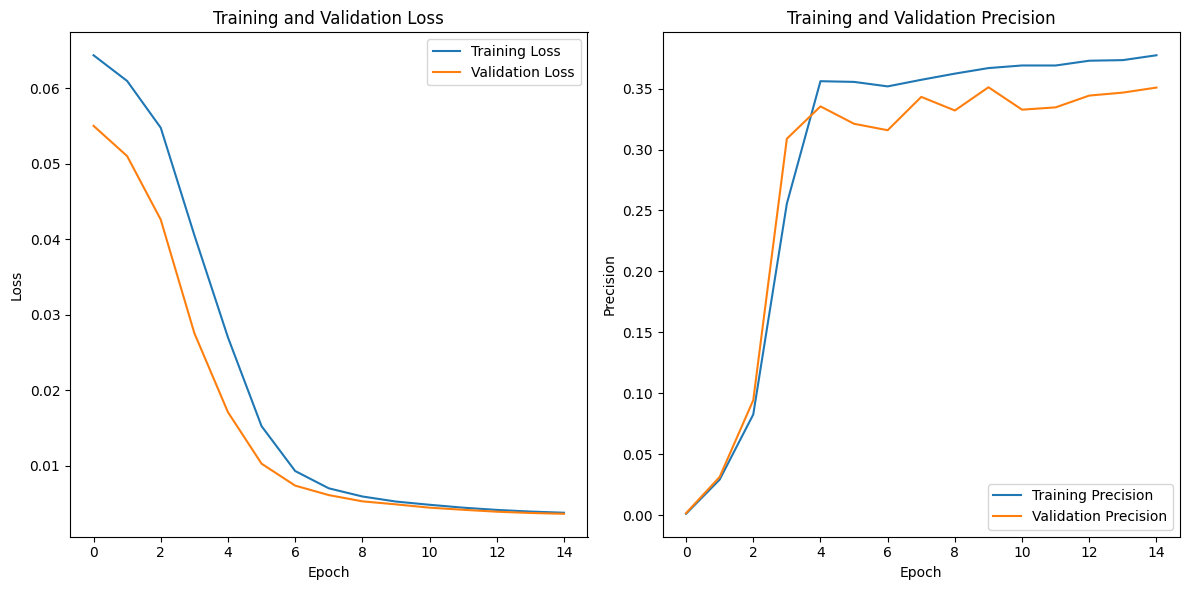

In [63]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axs[0].plot(ae_history.history['loss'], label='Training Loss')
axs[0].plot(ae_history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

# Plot training and validation precision
axs[1].plot(ae_history.history['precision'], label='Training Precision')
axs[1].plot(ae_history.history['val_precision'], label='Validation Precision')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Precision')
axs[1].set_title('Training and Validation Precision')
axs[1].legend()

plt.tight_layout()

# Show the plot
plt.show()


1/1 [==============================] - 0s 125ms/step
Accuracy: 62.50%

Sample 0: Original Label: Normal, Prediction: Anomalous
Sample 1: Original Label: Normal, Prediction: Anomalous
Sample 2: Original Label: Normal, Prediction: Anomalous
Sample 3: Original Label: Normal, Prediction: Anomalous
Sample 4: Original Label: Normal, Prediction: Anomalous
Sample 5: Original Label: Normal, Prediction: Anomalous
Sample 6: Original Label: Normal, Prediction: Anomalous
Sample 7: Original Label: Normal, Prediction: Anomalous
Sample 8: Original Label: Normal, Prediction: Anomalous
Sample 9: Original Label: Normal, Prediction: Anomalous
Sample 10: Original Label: Normal, Prediction: Anomalous
Sample 11: Original Label: Normal, Prediction: Anomalous
Sample 12: Original Label: Normal, Prediction: Anomalous
Sample 13: Original Label: Normal, Prediction: Anomalous
Sample 14: Original Label: Normal, Prediction: Anomalous
Sample 15: Original Label: Normal, Prediction: Anomalous



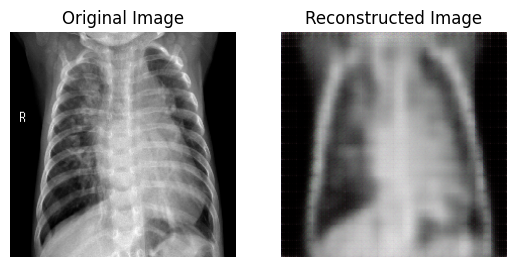

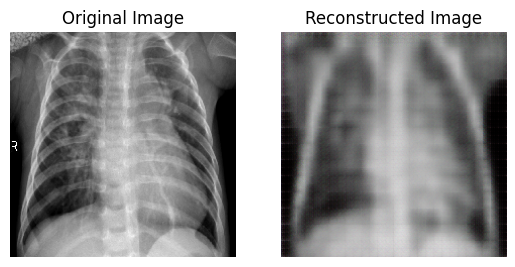

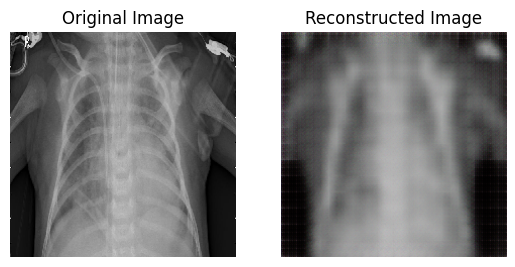

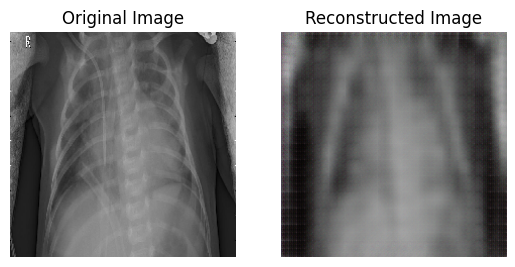

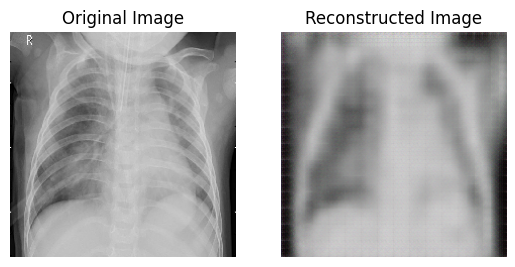

In [64]:
test_labels = test_generator.classes
threshold = 0.017

predictions = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_reconstructed_images = autoencoder.predict(batch_images)
    batch_errors = np.mean(np.abs(batch_images - batch_reconstructed_images), axis=(1, 2, 3))
    predictions.extend(batch_errors > threshold)


# Convert predictions to binary classification (1: anomalous, 0: normal)
predictions = np.array(predictions, dtype=int)

accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')
print()

# Print the predictions alongside the original labels
for i, (prediction, label) in enumerate(zip(predictions, batch_labels.tolist())):
    # Adjust indexing if batch_labels is multi-dimensional
    original_label = "Pneumonia" if label[0] == 1 else "Normal"
    anomaly_status = "Anomalous" if prediction == 1 else "Normal"
    print(f"Sample {i}: Original Label: {original_label}, Prediction: {anomaly_status}")

print()

# Visualize some reconstructed images (for inspection)
num_images_to_visualize = 5
for i in range(num_images_to_visualize):
    original_image = batch_images[i]
    reconstructed_image = batch_reconstructed_images[i]

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image)
    plt.axis('off')

    plt.show()
